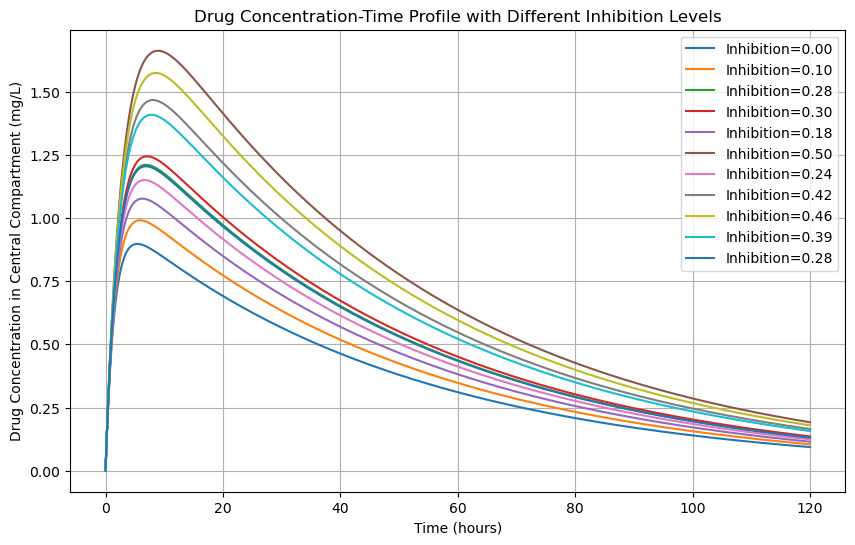

    Inhibition        AUC      Cmax      AUC_we   Cmax_we  RatioAUC_we  \
0     0.000000  45.320475  0.897145   46.138334  1.051910     1.000000   
1     0.102555  50.481446  0.990649   61.236910  1.114890     1.327246   
2     0.280355  62.898379  1.210158   60.041303  1.503691     1.301332   
3     0.301900  64.830397  1.243624   75.978315  0.649813     1.646750   
4     0.180662  55.275210  1.076327   67.940755  0.724541     1.472545   
5     0.496603  89.740241  1.661379   72.163907  0.929173     1.564077   
6     0.238401  59.448101  1.149882   56.890630  0.896843     1.233045   
7     0.419727  77.920121  1.466262   78.624695  1.582349     1.704108   
8     0.464294  84.362090  1.573231  105.850496  1.896171     2.294198   
9     0.392513  74.448313  1.407892   71.749911  1.472449     1.555104   
10    0.276364  62.552936  1.204129   22.263171  1.302173     0.482531   

    RatioAUC  
0   1.000000  
1   1.113877  
2   1.387858  
3   1.430488  
4   1.219652  
5   1.980126  
6   1.

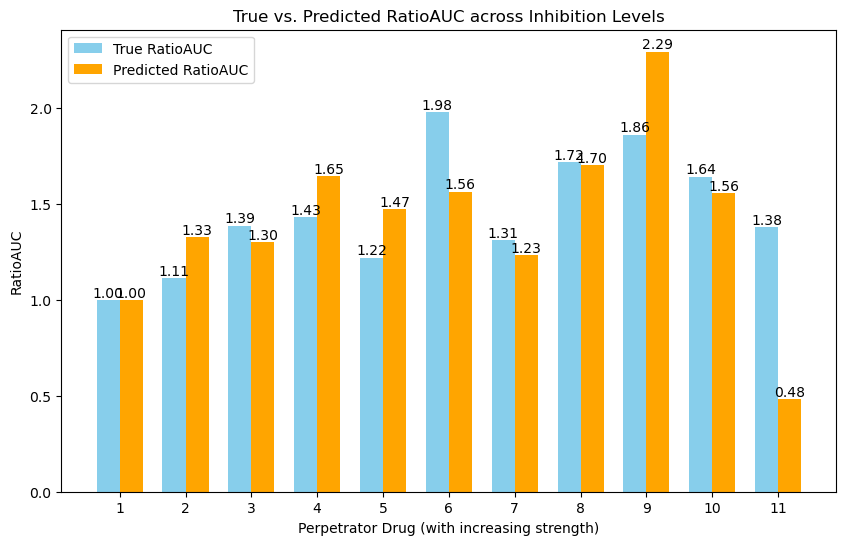

In [58]:
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the Antimony model
model = '''
model one_compartment_pk_model
    // Parameters for drug movement
    dose = 100 milligram;           # Initial dose (mg)
    infusiontime = 10 hour;
    k_a0 = dose / infusiontime;     # Zero-order absorption rate (mg/h)
    k_a1 = 0.02 per_hour;           # First-order absorption rate constant (1/h)
    
    CL_base = 2 per_hour;           # Baseline clearance (L/h)
    Vcentral = 3 litre;             # Volume of central compartment (L)
    Vdepot = 1 litre;               # Volume of depot compartment (L)
    
    // Covariate effect on clearance
    Covariate = 1;                 # Covariate multiplier (e.g., could represent renal function)
    
    // Inhibition effect on clearance
    Inhibition = 0;                # Inhibition fraction (0 = no inhibition, 1 = full inhibition)
    
    // Adjusted clearance incorporating covariate and inhibition
    CL := CL_base * Covariate * (1 - Inhibition);

    // Define compartments
    compartment Central, Depot;
    Central := Vcentral;  # Central compartment volume
    Depot := Vdepot;      # Depot compartment volume

    // Define species
    species Drug_Central in Central, Drug_Depot in Depot;

    // Initial conditions
    Drug_Central = 0 milligram_per_litre;   # Initial drug concentration in central compartment
    Drug_Depot = dose / Vdepot;             # Initial drug concentration in depot compartment

    // Reactions for drug movement
    Absorption: Drug_Depot -> Drug_Central; k_a1 * Drug_Depot;  // First-order absorption
    Clearance: Drug_Central -> ; CL * Drug_Central;             # Elimination
    
    // Output
    A_central := Drug_Central * Vcentral;  # Amount of drug in the central compartment (mg)
    
end
'''

numberofperpetrators=10

# Define simulation parameters
time_end = 24*5  # Simulation time (hours)
num_points = 500  # Number of time points

# Simulate the model for a range of inhibition scenarios by altering the Inhibition parameter
inhibition_values = np.linspace(0, 0.5, numberofperpetrators)  # Range from no inhibition to full inhibition
inhibition_values = [0]+ list(np.random.uniform(0, 0.5, numberofperpetrators))  # Range from no inhibition to full inhibition
covariate_value = 1.0  # Can adjust this to simulate different covariate effects
results = []
resultsanalysis=[]

print("hello")

r = te.loada(model)

for inhibition in inhibition_values:
    r.resetAll()
    r["Inhibition"] = inhibition
    r["Covariate"] = covariate_value  # Apply covariate effect (e.g., representing renal function)
    result = r.simulate(0, time_end, num_points)
    results.append((inhibition, result))
    # Calculate AUC and Cmax
    AUC_central = np.trapz(result['[Drug_Central]'], result['time'])
    Cmax_central = np.max(result['[Drug_Central]'])
    # Append the results to the data list
    resultsanalysis.append({'Inhibition': inhibition, 'AUC': AUC_central, 'Cmax': Cmax_central})

# Plotting the results
plt.figure(figsize=(10, 6))
for inhibition, result in results:
    plt.plot(result['time'], result['[Drug_Central]'], label=f'Inhibition={inhibition:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('Drug Concentration in Central Compartment (mg/L)')
plt.title('Drug Concentration-Time Profile with Different Inhibition Levels')
plt.legend()
plt.grid(True)
plt.show()


# Convert the data list to a Pandas DataFrame
resultsanalysisdf = pd.DataFrame(resultsanalysis)
error_cv_auc=0.2
error_sd_cmax=0.25
# Apply proportional error to AUC and additive error to Cmax
resultsanalysisdf['AUC_we'] = resultsanalysisdf['AUC'] * (1 + np.random.normal(0, error_cv_auc, size=len(resultsanalysisdf)))
resultsanalysisdf['Cmax_we'] = resultsanalysisdf['Cmax'] + np.random.normal(0, error_sd_cmax * resultsanalysisdf['Cmax'], size=len(resultsanalysisdf))
# Calculate RatioAUC_we in one line
resultsanalysisdf['RatioAUC_we'] = resultsanalysisdf['AUC_we'] / resultsanalysisdf.loc[resultsanalysisdf['Inhibition'] == 0, 'AUC_we'].values[0]
resultsanalysisdf['RatioAUC'] = resultsanalysisdf['AUC'] / resultsanalysisdf.loc[resultsanalysisdf['Inhibition'] == 0, 'AUC'].values[0]

print(resultsanalysisdf)

df=resultsanalysisdf
df['Inhibition'] = df['Inhibition'].astype(str)  # Convert Inhibition to categorical

# Set up the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(df['Inhibition']))

# Plot the true RatioAUC
bar1 = ax.bar(index, df['RatioAUC'], bar_width, label='True RatioAUC', color='skyblue')

# Plot the observed RatioAUC_we
bar2 = ax.bar(index + bar_width, df['RatioAUC_we'], bar_width, label='Predicted RatioAUC', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Perpetrator Drug (with increasing strength)')
ax.set_ylabel('RatioAUC')
ax.set_title('True vs. Predicted RatioAUC across Inhibition Levels')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(np.arange(1, len(df) + 1))
ax.legend()

# Add value annotations on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Save the plot
plt.savefig("Grouped_RatioAUC_vs_Inhibition.png", dpi=300, bbox_inches='tight')
plt.show()


In [59]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import resample

# Assuming df is your DataFrame with 'RatioAUC' (true values) and 'RatioAUC_we' (observed values)
true_values = df['RatioAUC']
observed_values = df['RatioAUC_we']

# Calculate Pearson and Spearman correlation coefficients
pearson_corr, _ = stats.pearsonr(true_values, observed_values)
spearman_corr, _ = stats.spearmanr(true_values, observed_values)

# Calculate R^2 values
pearson_r2 = pearson_corr**2
spearman_r2 = spearman_corr**2

# Bootstrapping for 95% CI of R^2
n_iterations = 1000
pearson_r2_random = []
spearman_r2_random = []

for i in range(n_iterations):
    # Resample the true values with replacement
    true_resampled = resample(true_values, replace=True)
    
    # Compute the correlation coefficients for the resampled data
    pearson_r, _ = stats.pearsonr(true_resampled, observed_values)
    spearman_r, _ = stats.spearmanr(true_resampled, observed_values)
    
    # Store the R^2 results
    pearson_r2_random.append(pearson_r**2)
    spearman_r2_random.append(spearman_r**2)

# Calculate the 95% confidence intervals for the bootstrapped R^2 values
pearson_r2_ci = np.percentile(pearson_r2_random, [2.5, 97.5])
spearman_r2_ci = np.percentile(spearman_r2_random, [2.5, 97.5])

# Output results
print(f"Pearson R^2: {pearson_r2:.3f}")
print(f"Spearman R^2: {spearman_r2:.3f}")
print(f"95% CI for random Pearson R^2 (bootstrapped): {pearson_r2_ci}")
print(f"95% CI for random Spearman R^2 (bootstrapped): {spearman_r2_ci}")

Pearson R^2: 0.361
Spearman R^2: 0.556
95% CI for random Pearson R^2 (bootstrapped): [1.03846879e-04 4.44149005e-01]
95% CI for random Spearman R^2 (bootstrapped): [8.41653866e-05 4.46593165e-01]


11


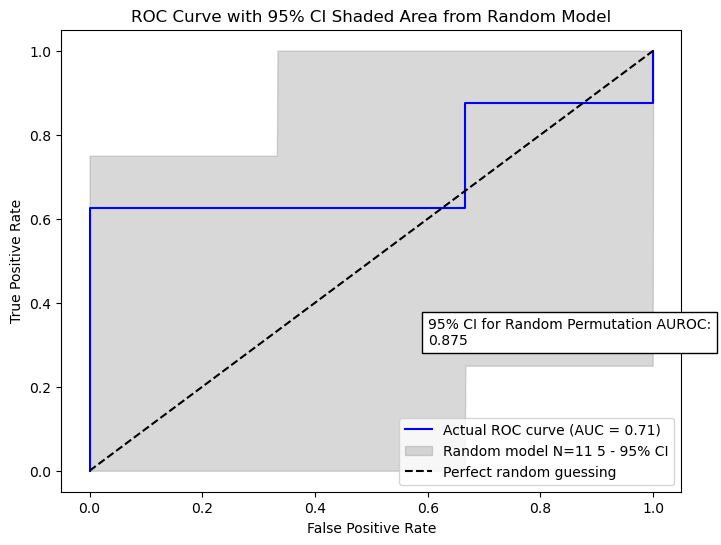

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
# True DDI classifications based on RatioAUC

random_auc_scores=[]

true_labels = (df['RatioAUC'] > 1.25).astype(int)
true_values=df['RatioAUC']
datalength=df.shape[0]
print(datalength)

# Predicted DDI values based on RatioAUC_we
predicted_values = df['RatioAUC_we']

# Calculate the actual ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_values)
roc_auc = roc_auc_score(true_labels, predicted_values)

# Initialize lists to hold FPR, TPR values for randomly permuted labels
random_tpr_list = []
random_fpr = np.linspace(0, 1, 1000)  # Fixed FPR points for interpolation

# Number of permutations
n_permutations = 1000

# Perform the permutations
for i in range(n_permutations):
    # Permute the true labels
    permuted_labels = np.random.permutation(true_labels)
    
    # Calculate the ROC curve for the permuted labels
    permuted_fpr, permuted_tpr, _ = roc_curve(permuted_labels, predicted_values)
    
    # Interpolate the TPR values to match the fixed FPR points
    interp_tpr = np.interp(random_fpr, permuted_fpr, permuted_tpr)
    random_tpr_list.append(interp_tpr)

    # Calculate the AUC for the permuted labels
    random_auc = roc_auc_score(permuted_labels, true_values)
    random_auc_scores.append(random_auc)

# Convert the list of TPRs to a numpy array
random_tpr_array = np.array(random_tpr_list)

# Calculate the 95% confidence interval for the TPR values at each FPR point
tpr_lower_bound = np.percentile(random_tpr_array, 2.5, axis=0)
tpr_upper_bound = np.percentile(random_tpr_array, 97.5, axis=0)

# Calculate the 95% confidence interval for the AUC of the random model
auroc_lower_bound = np.percentile(random_auc_scores, 2.5)
auroc_upper_bound = np.percentile(random_auc_scores, 97.5)

# Plot the actual ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Actual ROC curve (AUC = {roc_auc:.2f})')

# Plot the random model ROC curve as a shaded area (95% CI)
plt.fill_between(random_fpr, tpr_lower_bound, tpr_upper_bound, color='gray', alpha=0.3, label=f'Random model N={datalength} 5 - 95% CI')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfect random guessing')

# Add the auroc confidence interval to the plot as text
plt.text(0.6, 0.3, f'95% CI for Random Permutation AUROC:\n{auroc_upper_bound:.3f}', 
         bbox=dict(facecolor='white', alpha=1.0), fontsize=10)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 95% CI Shaded Area from Random Model')
plt.legend(loc="lower right")

plt.show()

